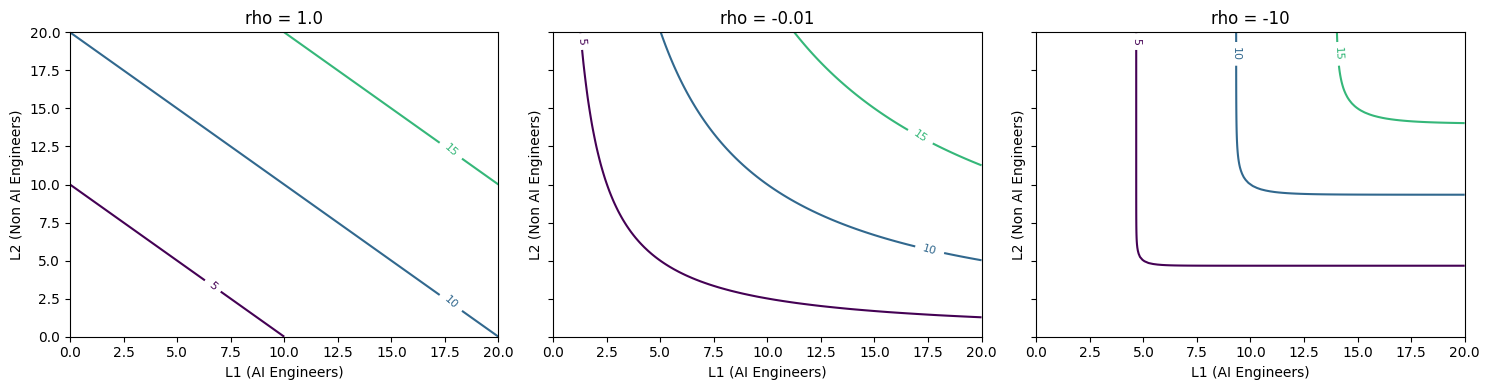


=== Scenario 1 ===
Equilibrium Results:

            Variable  Eq(Old)  Eq(New)
           Price (p)    72.00    25.43
    Wage AI Eng (w1)    36.00    43.56
Wage Non AI Eng (w2)    36.00    23.53
         AI Eng (L1)    28.00    31.78
     Non AI Eng (L2)    28.00    21.77
        Products (Y)    28.00    74.57 

Parameters Table:

               Parameter             Definition  Old Value  New Value
          A (Technology)         CES Tech param       1.00       5.00
        Beta (CES Share)        CES Share param       0.50       0.50
    rho (CES Elasticity)   CES Elasticity param       0.50       0.50
alpha (Demand Intercept) Goods demand intercept     100.00     100.00
   beta_g (Demand Slope)     Goods demand slope       1.00       1.00
   a (Labor Supply Base)      Base labor supply      10.00      10.00
  b (Labor Supply Slope)  Slope of labor supply       0.50       0.50 



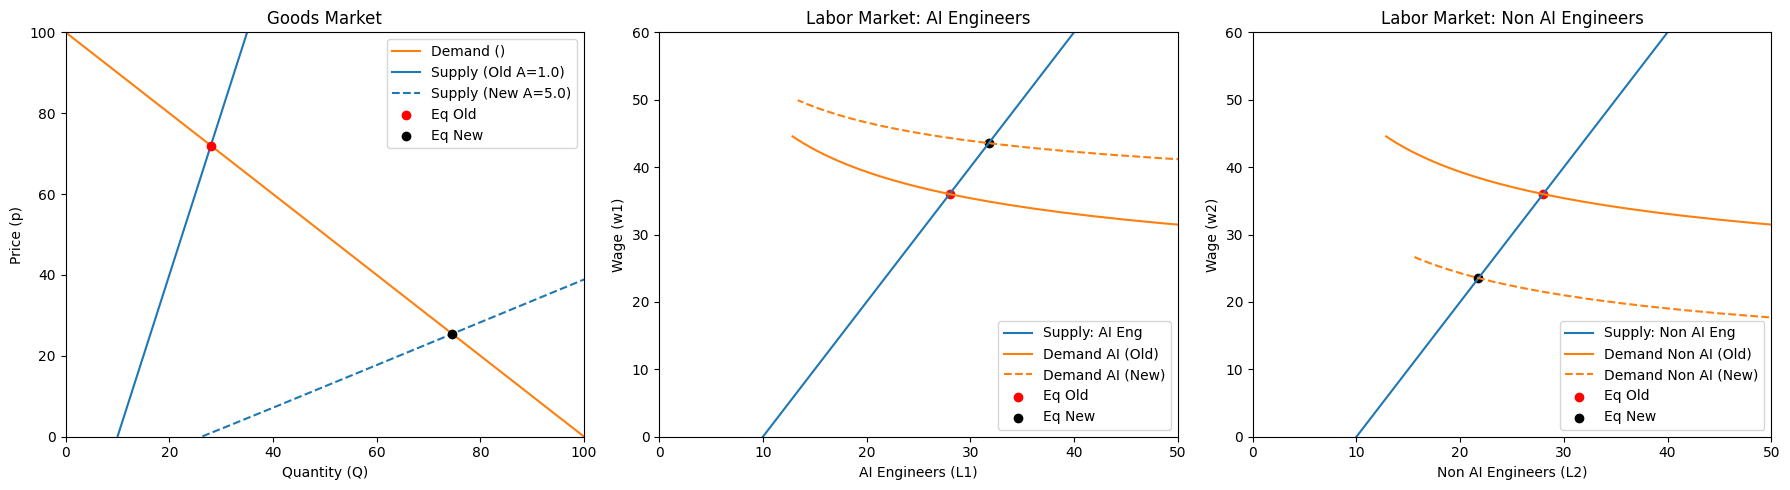


=== Scenario 2 ===
Equilibrium Results:

            Variable  Eq(Old)  Eq(New)
           Price (p)    72.00    34.66
    Wage AI Eng (w1)    36.00    38.44
Wage Non AI Eng (w2)    36.00    38.81
         AI Eng (L1)    28.00    29.22
     Non AI Eng (L2)    28.00    29.41
        Products (Y)    28.00    65.34 

Parameters Table:

               Parameter             Definition  Old Value  New Value
          A (Technology)         CES Tech param       1.00       5.00
        Beta (CES Share)        CES Share param       0.50       0.50
    rho (CES Elasticity)   CES Elasticity param      -0.01      -0.01
alpha (Demand Intercept) Goods demand intercept     100.00     100.00
   beta_g (Demand Slope)     Goods demand slope       1.00       1.00
   a (Labor Supply Base)      Base labor supply      10.00      10.00
  b (Labor Supply Slope)  Slope of labor supply       0.50       0.50 



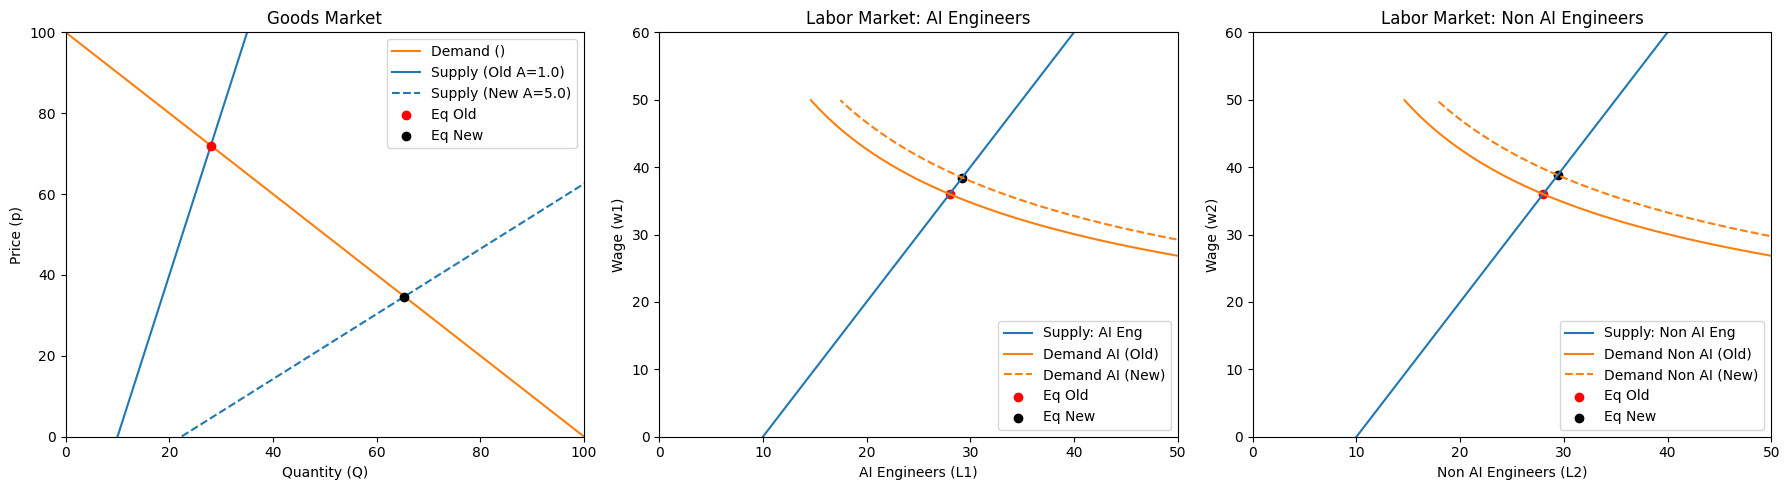


=== Scenario 3 ===
Equilibrium Results:

            Variable  Eq(Old)  Eq(New)
           Price (p)    72.00    40.92
    Wage AI Eng (w1)    36.00    31.66
Wage Non AI Eng (w2)    36.00    47.44
         AI Eng (L1)    28.00    25.83
     Non AI Eng (L2)    28.00    33.72
        Products (Y)    28.00    59.08 

Parameters Table:

               Parameter             Definition  Old Value  New Value
          A (Technology)         CES Tech param       1.00       5.00
        Beta (CES Share)        CES Share param       0.50       0.50
    rho (CES Elasticity)   CES Elasticity param      -0.50      -0.50
alpha (Demand Intercept) Goods demand intercept     100.00     100.00
   beta_g (Demand Slope)     Goods demand slope       1.00       1.00
   a (Labor Supply Base)      Base labor supply      10.00      10.00
  b (Labor Supply Slope)  Slope of labor supply       0.50       0.50 



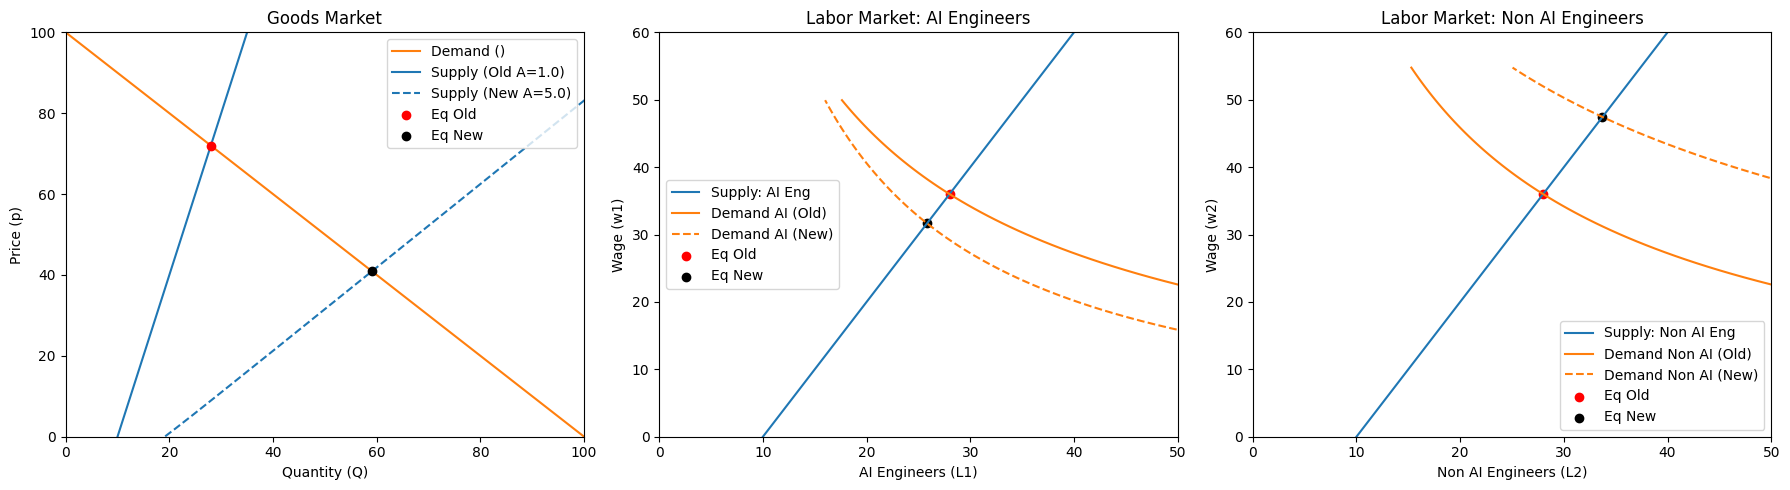

In [140]:
import numpy as np
import matplotlib.pyplot as plt

def safe_power(x, power):
    return np.maximum(x, 1e-14)**power

def ces_production(L1, L2, A, Beta, rho):
    """CES production function: Q = [Beta*(A*L1)^rho + (1-Beta)*(L2)^rho]^(1/rho)."""
    part1 = safe_power(A * L1, rho)
    part2 = safe_power(L2,      rho)
    inside = Beta*part1 + (1 - Beta)*part2
    return safe_power(inside, 1.0 / rho)

def plot_isoquants(rho_values, A=1.0, Beta=0.5, Lmax=20, n_points=100, Q_levels=[5, 10, 15, 20]):
    """
    Plots isoquants for different rho (substitution) values of the CES production function.
    rho_values: list of rho's to visualize
    A, Beta: CES parameters
    Lmax: maximum labor on each axis
    n_points: resolution of the grid
    Q_levels: the output levels for the isoquant contours
    """
    # Prepare L1, L2 grid
    L1 = np.linspace(0, Lmax, n_points)
    L2 = np.linspace(0, Lmax, n_points)
    L1_mesh, L2_mesh = np.meshgrid(L1, L2)
    
    fig, axes = plt.subplots(1, len(rho_values), figsize=(5 * len(rho_values), 4), sharey=True)
    if len(rho_values) == 1:
        axes = [axes]  # Make it iterable if only one subplot

    for ax, rho in zip(axes, rho_values):
        # Compute output Q over the grid
        Q = ces_production(L1_mesh, L2_mesh, A, Beta, rho)
        
        # Plot contours for isoquants
        cs = ax.contour(L1_mesh, L2_mesh, Q, levels=Q_levels, cmap='viridis')
        ax.clabel(cs, inline=True, fontsize=8)
        
        ax.set_title(f"rho = {rho}")
        ax.set_xlabel("L1 (AI Engineers)")
        ax.set_ylabel("L2 (Non AI Engineers)")
        ax.set_xlim(0, Lmax)
        ax.set_ylim(0, Lmax)
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Compare three rho values
    rhos = [1.0, -0.01, -10]
    plot_isoquants(rho_values=rhos, A=1.0, Beta=0.5, Lmax=20, n_points=100, Q_levels=[5, 10, 15, 20])

import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

##############################################################################
# HELPER: Safely compute (x)^power, clamping x to avoid negatives/zero
##############################################################################
def safe_power(x, power):
    return (max(x, 1e-14))**power

##############################################################################
# 1) CES production & correct derivatives (no extra rho factor)
##############################################################################
def ces_production(L1, L2, A, Beta, rho):
    with np.errstate(invalid='ignore', divide='ignore'):
        part1 = safe_power(A*L1, rho)
        part2 = safe_power(L2,  rho)
        inside = Beta*part1 + (1 - Beta)*part2
        return safe_power(inside, 1.0/rho)

def dYdL1(L1, L2, A, Beta, rho):
    with np.errstate(invalid='ignore', divide='ignore'):
        inside = Beta*safe_power(A*L1, rho) + (1 - Beta)*safe_power(L2, rho)
        factor = safe_power(inside, (1.0/rho) - 1.0)
        return Beta * factor * A * safe_power(A*L1, rho - 1)

def dYdL2(L1, L2, A, Beta, rho):
    with np.errstate(invalid='ignore', divide='ignore'):
        inside = Beta*safe_power(A*L1, rho) + (1 - Beta)*safe_power(L2, rho)
        factor = safe_power(inside, (1.0/rho) - 1.0)
        return (1 - Beta) * factor * safe_power(L2, rho - 1)

##############################################################################
# 2) Equilibrium system (5 equations)
##############################################################################
def equilibrium_system(vars, A, Beta, rho, alpha, beta_g, a, b):
    p, w1, w2, L1, L2 = vars
    eq1 = w1 - p*dYdL1(L1, L2, A, Beta, rho)
    eq2 = w2 - p*dYdL2(L1, L2, A, Beta, rho)
    eq3 = L1 - (a + b*w1)
    eq4 = L2 - (a + b*w2)
    Y   = ces_production(L1, L2, A, Beta, rho)
    eq5 = alpha - beta_g*p - Y
    return (eq1, eq2, eq3, eq4, eq5)

##############################################################################
# 3) Solve for general equilibrium
##############################################################################
def solve_equilibrium(A=2.0, Beta=0.5, rho=0.5, alpha=100.0,
                      beta_g=1.0, a=10.0, b=0.5):
    guess = (20.0, 10.0, 10.0, a + b*10, a + b*10)
    sol = fsolve(equilibrium_system, guess,
                 args=(A, Beta, rho, alpha, beta_g, a, b),
                 xtol=1e-10, maxfev=5000)
    p_star, w1_star, w2_star, L1_star, L2_star = sol
    Y_star = ces_production(L1_star, L2_star, A, Beta, rho)
    return p_star, w1_star, w2_star, L1_star, L2_star, Y_star

##############################################################################
# 4) Partial-equilibrium (Goods Supply) for each p
##############################################################################
def goods_supply_curve(p_array, A, Beta, rho, a, b):
    supply_vals = []
    for p in p_array:
        def sub_system(x):
            w1_, w2_, L1_, L2_ = x
            eq1 = w1_ - p*dYdL1(L1_, L2_, A, Beta, rho)
            eq2 = w2_ - p*dYdL2(L1_, L2_, A, Beta, rho)
            eq3 = L1_ - (a + b*w1_)
            eq4 = L2_ - (a + b*w2_)
            return (eq1, eq2, eq3, eq4)

        init_guess = (10.0, 10.0, a + b*10, a + b*10)
        sol_sub = fsolve(sub_system, init_guess, xtol=1e-10, maxfev=3000)
        w1__, w2__, L1__, L2__ = sol_sub
        Y__ = ces_production(L1__, L2__, A, Beta, rho)
        supply_vals.append(Y__)
    return np.array(supply_vals)

##############################################################################
# 5) Partial-equilibrium labor demand
##############################################################################
def labor_demand_L1(w_array, p_fix, A, Beta, rho, L2_fix):
    Ld1 = []
    for w_ in w_array:
        def eq_L1(L1_):
            return dYdL1(L1_, L2_fix, A, Beta, rho) - (w_/p_fix)
        guess = max(L2_fix, 1.0)
        sol_L1 = fsolve(eq_L1, guess, xtol=1e-10, maxfev=3000)
        L1_res = max(sol_L1[0], 0)
        Ld1.append(L1_res)
    return np.array(Ld1)

def labor_demand_L2(w_array, p_fix, A, Beta, rho, L1_fix):
    Ld2 = []
    for w_ in w_array:
        def eq_L2(L2_):
            return dYdL2(L1_fix, L2_, A, Beta, rho) - (w_/p_fix)
        guess = max(L1_fix, 1.0)
        sol_L2 = fsolve(eq_L2, guess, xtol=1e-10, maxfev=3000)
        L2_res = max(sol_L2[0], 0)
        Ld2.append(L2_res)
    return np.array(Ld2)

##############################################################################
# SIMULATION function: run_simulation
##############################################################################
def run_simulation(A_old, A_new, Beta, rho, alpha, beta_g, a, b):
    eqOld = solve_equilibrium(A_old, Beta, rho, alpha, beta_g, a, b)
    eqNew = solve_equilibrium(A_new, Beta, rho, alpha, beta_g, a, b)
    p_old, w1_old, w2_old, L1_old, L2_old, Y_old = eqOld
    p_new, w1_new, w2_new, L1_new, L2_new, Y_new = eqNew

    p_grid = np.linspace(0.1, 100, 150)
    supplyOld = goods_supply_curve(p_grid, A_old, Beta, rho, a, b)
    supplyNew = goods_supply_curve(p_grid, A_new, Beta, rho, a, b)
    demand_vals = np.clip(alpha - beta_g*p_grid, 0, None)

    w_grid = np.linspace(0, 80, 150)
    L1_supply = a + b*w_grid
    L2_supply = a + b*w_grid

    L1_demand_old = labor_demand_L1(w_grid, p_old, A_old, Beta, rho, L2_old)
    L1_demand_new = labor_demand_L1(w_grid, p_new, A_new, Beta, rho, L2_new)
    L2_demand_old = labor_demand_L2(w_grid, p_old, A_old, Beta, rho, L1_old)
    L2_demand_new = labor_demand_L2(w_grid, p_new, A_new, Beta, rho, L1_new)

    return {
        'p_old': p_old, 'w1_old': w1_old, 'w2_old': w2_old,
        'L1_old': L1_old, 'L2_old': L2_old, 'Y_old': Y_old,
        'p_new': p_new, 'w1_new': w1_new, 'w2_new': w2_new,
        'L1_new': L1_new, 'L2_new': L2_new, 'Y_new': Y_new,

        'p_grid': p_grid,
        'supplyOld': supplyOld,
        'supplyNew': supplyNew,
        'demand_vals': demand_vals,

        'w_grid': w_grid,
        'L1_supply': L1_supply,
        'L2_supply': L2_supply,
        'L1_demand_old': L1_demand_old,
        'L1_demand_new': L1_demand_new,
        'L2_demand_old': L2_demand_old,
        'L2_demand_new': L2_demand_new
    }

##############################################################################
# PLOTTING function: plot_results
##############################################################################
def plot_results(sim_data, A_old, A_new, wcap_old_L1=50, wcap_new_L1=50,
                 wcap_old_L2=50, wcap_new_L2=50):
    p_old, w1_old, w2_old, L1_old, L2_old, Y_old = (
        sim_data['p_old'], sim_data['w1_old'], sim_data['w2_old'],
        sim_data['L1_old'], sim_data['L2_old'], sim_data['Y_old']
    )
    p_new, w1_new, w2_new, L1_new, L2_new, Y_new = (
        sim_data['p_new'], sim_data['w1_new'], sim_data['w2_new'],
        sim_data['L1_new'], sim_data['L2_new'], sim_data['Y_new']
    )

    p_grid      = sim_data['p_grid']
    supplyOld   = sim_data['supplyOld']
    supplyNew   = sim_data['supplyNew']
    demand_vals = sim_data['demand_vals']

    w_grid         = sim_data['w_grid']
    L1_supply      = sim_data['L1_supply']
    L2_supply      = sim_data['L2_supply']
    L1_demand_old  = sim_data['L1_demand_old']
    L1_demand_new  = sim_data['L1_demand_new']
    L2_demand_old  = sim_data['L2_demand_old']
    L2_demand_new  = sim_data['L2_demand_new']

    # Apply scenario-specific wage caps
    mask_old_L1 = w_grid <= wcap_old_L1
    mask_new_L1 = w_grid <= wcap_new_L1
    mask_old_L2 = w_grid <= wcap_old_L2
    mask_new_L2 = w_grid <= wcap_new_L2

    L1_demand_old_clipped = L1_demand_old[mask_old_L1]
    w_grid_old_L1         = w_grid[mask_old_L1]
    L1_demand_new_clipped = L1_demand_new[mask_new_L1]
    w_grid_new_L1         = w_grid[mask_new_L1]

    L2_demand_old_clipped = L2_demand_old[mask_old_L2]
    w_grid_old_L2         = w_grid[mask_old_L2]
    L2_demand_new_clipped = L2_demand_new[mask_new_L2]
    w_grid_new_L2         = w_grid[mask_new_L2]

    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    # (a) Goods Market
    ax = axes[0]
    ax.plot(demand_vals, p_grid, label="Demand ()", color="C1")
    ax.plot(supplyOld, p_grid, label=f"Supply (Old A={A_old})", color="C0")
    ax.plot(supplyNew, p_grid, label=f"Supply (New A={A_new})", color="C0", linestyle="--")
    ax.scatter(Y_old, p_old, color="red", label="Eq Old", zorder=5)
    ax.scatter(Y_new, p_new, color="black", label="Eq New", zorder=5)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xlabel("Quantity (Q)")
    ax.set_ylabel("Price (p)")
    ax.set_title("Goods Market")
    ax.legend()

    # (b) Labor Market: AI Engineers (L1)
    ax = axes[1]
    ax.plot(L1_supply, w_grid, label="Supply: AI Eng", color="C0")
    ax.plot(L1_demand_old_clipped, w_grid_old_L1, label="Demand AI (Old)", color="C1")
    ax.plot(L1_demand_new_clipped, w_grid_new_L1, label="Demand AI (New)", color="C1", linestyle="--")
    ax.scatter(L1_old, w1_old, color="red", label="Eq Old")
    ax.scatter(L1_new, w1_new, color="black", label="Eq New")
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 60)
    ax.set_xlabel("AI Engineers (L1)")
    ax.set_ylabel("Wage (w1)")
    ax.set_title("Labor Market: AI Engineers")
    ax.legend()

    # (c) Labor Market: Non AI Engineers (L2)
    ax = axes[2]
    ax.plot(L2_supply, w_grid, label="Supply: Non AI Eng", color="C0")
    ax.plot(L2_demand_old_clipped, w_grid_old_L2, label="Demand Non AI (Old)", color="C1")
    ax.plot(L2_demand_new_clipped, w_grid_new_L2, label="Demand Non AI (New)", color="C1", linestyle="--")
    ax.scatter(L2_old, w2_old, color="red", label="Eq Old")
    ax.scatter(L2_new, w2_new, color="black", label="Eq New")
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 60)
    ax.set_xlabel("Non AI Engineers (L2)")
    ax.set_ylabel("Wage (w2)")
    ax.set_title("Labor Market: Non AI Engineers")
    ax.legend()

    plt.tight_layout()
    plt.show()

##############################################################################
# MAIN
##############################################################################
if __name__ == "__main__":

    # Common parameters for the scenarios
    A_old, A_new = 1.0, 5.0
    Beta = 0.5
    alpha, beta_g = 100.0, 1.0
    a, b = 10.0, 0.5

    # Define different scenarios with distinct rho and wage caps
    scenarios = [
        {
            'name': "Scenario 1",
            'rho': 0.5,
            'wcap_old_L1': 45,
            'wcap_new_L1': 50,
            'wcap_old_L2': 45,
            'wcap_new_L2': 27
        },
        {
            'name': "Scenario 2",
            'rho': -0.01,
            'wcap_old_L1': 50,
            'wcap_new_L1': 50,
            'wcap_old_L2': 50,
            'wcap_new_L2': 50
        },
        {
            'name': "Scenario 3",
            'rho': -0.5,
            'wcap_old_L1': 50,
            'wcap_new_L1': 50,
            'wcap_old_L2': 55,
            'wcap_new_L2': 55
        }
    ]

    for scenario in scenarios:
        print(f"\n=== {scenario['name']} ===")
        # Run simulation
        results = run_simulation(
            A_old=A_old,
            A_new=A_new,
            Beta=Beta,
            rho=scenario['rho'],
            alpha=alpha,
            beta_g=beta_g,
            a=a,
            b=b
        )

        # Print equilibrium table
        eq_table = pd.DataFrame({
            'Variable': [
                'Price (p)', 'Wage AI Eng (w1)', 'Wage Non AI Eng (w2)',
                'AI Eng (L1)', 'Non AI Eng (L2)', 'Products (Y)'
            ],
            'Eq(Old)': [
                results['p_old'], results['w1_old'], results['w2_old'],
                results['L1_old'], results['L2_old'], results['Y_old']
            ],
            'Eq(New)': [
                results['p_new'], results['w1_new'], results['w2_new'],
                results['L1_new'], results['L2_new'], results['Y_new']
            ]
        })
        print("Equilibrium Results:\n")
        print(eq_table.to_string(index=False, float_format='{:0.2f}'.format), "\n")

        # Print parameter table
        parameters = pd.DataFrame({
            'Parameter': [
                'A (Technology)', 'Beta (CES Share)', 'rho (CES Elasticity)',
                'alpha (Demand Intercept)', 'beta_g (Demand Slope)',
                'a (Labor Supply Base)', 'b (Labor Supply Slope)'
            ],
            'Definition': [
                'CES Tech param', 'CES Share param', 'CES Elasticity param',
                'Goods demand intercept', 'Goods demand slope',
                'Base labor supply', 'Slope of labor supply'
            ],
            'Old Value': [A_old, Beta, scenario['rho'], alpha, beta_g, a, b],
            'New Value': [A_new, Beta, scenario['rho'], alpha, beta_g, a, b]
        })
        print("Parameters Table:\n")
        print(parameters.to_string(index=False, float_format='{:0.2f}'.format), "\n")

        # Plot results with scenario-specific wage caps
        plot_results(
            sim_data=results,
            A_old=A_old,
            A_new=A_new,
            wcap_old_L1=scenario['wcap_old_L1'],
            wcap_new_L1=scenario['wcap_new_L1'],
            wcap_old_L2=scenario['wcap_old_L2'],
            wcap_new_L2=scenario['wcap_new_L2']
        )
